Programmable state machines in rust
--------------------------------------------------------
- Author: [Timothy Hobbs](https://timothy.hobbs.cz)
- License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- Written: 1.2020
- Send PRs to: [github](https://github.com/timthelion/rust-jupyter)

[project homepage](https://github.com/timthelion/rust-pfsm) [ipynb](./pfsm.ipynb)

Rust has several finite state machine packages such as [`rust-fsm`](https://github.com/eugene-babichenko/rust-fsm). However, all of them are meant for state machines who's state network is known at compile time. I needed a programmable state machine, so wrote my own, with the help of the petgraph library.

Motivation
----------------

Programmable finite statemachines and or finite automata are best known for their use in the evaluation of regular expressions. Every regular expression can be converted into a parser wich is represented by a finite state machine \*. They also have many many other uses. For example, the keymap of a configurable modal text editor such as vim is a programable FSM.

\* Actually, this is no longer true. Modern PERL style regex is too powerful to represent all regular expressions as FSMs.

In [2]:
:dep petgraph-fsm = {path="./petgraph-fsm", features=["evcxr"]}

In [3]:
:dep petgraph = {path="./petgraph"}

In [4]:
extern crate petgraph_fsm;
extern crate petgraph;
use petgraph::*;
use petgraph_fsm::*;
use petgraph_fsm::evcxr::*;

 A "real" finite state machine does nothing but define:

 1. A set of valid sequences of inputs
 2. A mapping from each elemenent in each sequence to a state
 
Here is an FSM which describes the behavior of my toaster oven.

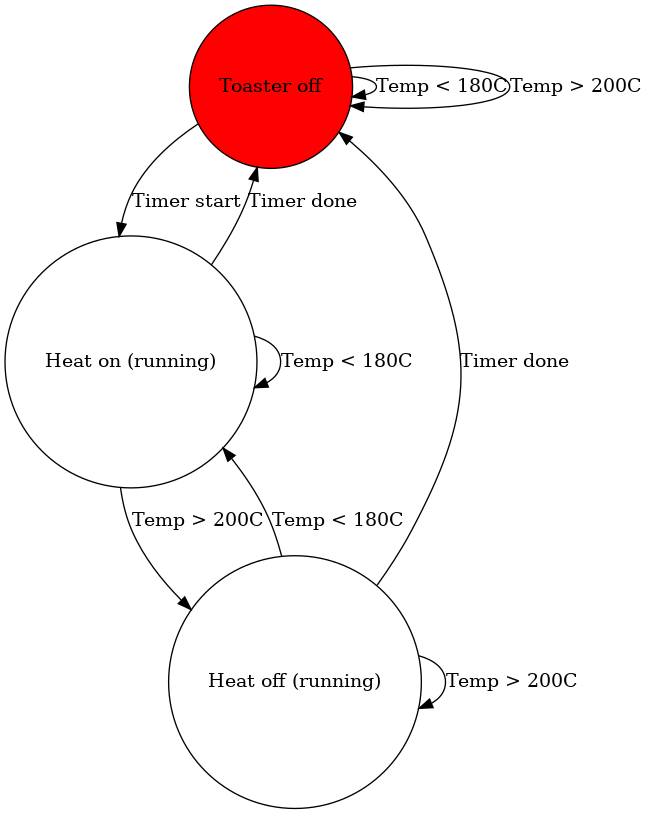

In [5]:
let mut toaster : Graph<&str, &str, petgraph::Directed> = Graph::new();
let toaster_off = toaster.add_node("Toaster off");
let heat_on = toaster.add_node("Heat on (running)");
let heat_off = toaster.add_node("Heat off (running)");
toaster.add_edge(toaster_off, heat_on, "Timer start");
toaster.add_edge(heat_on, toaster_off, "Timer done");
toaster.add_edge(heat_off, toaster_off, "Timer done");
toaster.add_edge(heat_on, heat_off, "Temp > 200C");
toaster.add_edge(heat_off, heat_off, "Temp > 200C");
toaster.add_edge(heat_off, heat_on, "Temp < 180C");
toaster.add_edge(heat_on, heat_on, "Temp < 180C");
toaster.add_edge(toaster_off, toaster_off, "Temp < 180C");
toaster.add_edge(toaster_off, toaster_off, "Temp > 200C");
let mut toaster_sm = StateMachine::new(
    toaster,
    "Toaster off",
    &|ew1: &str, ew2| {
        if ew1 == ew2 {Some(())} else {None}
    },
).unwrap();
toaster_sm.draw_evcxr();

Given this state machine, and a sequence of inputs, we can determine the state of the toaster.

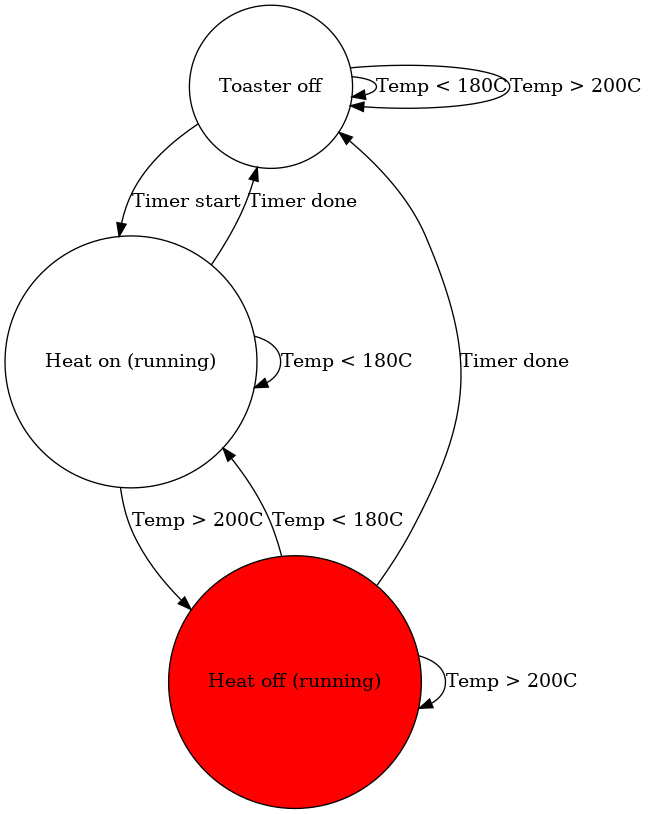

In [6]:
toaster_sm.next("Timer start");
toaster_sm.next("Temp < 180C");
toaster_sm.next("Temp > 200C");
toaster_sm.next("Temp > 200C");
toaster_sm.next("Temp < 180C");
toaster_sm.next("Temp < 180C");
toaster_sm.next("Temp > 200C");
toaster_sm.draw_evcxr();

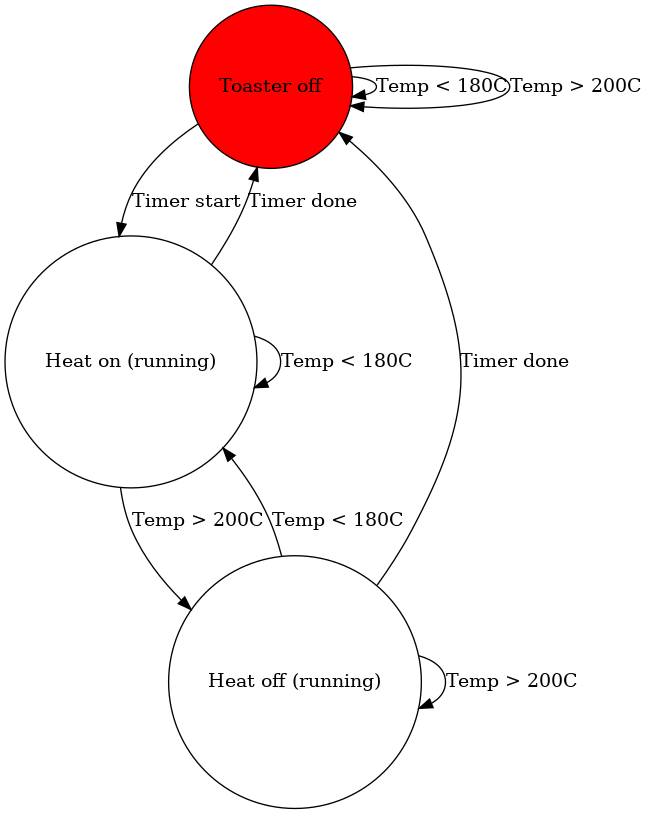

In [7]:
toaster_sm.next("Timer done");
toaster_sm.draw_evcxr();

This basic information is quite usefull in and of itself, and we can actually make a toaster controll circuit based on a state machine like this. If the state is "heat on" we make sure that the heat is turned on, otherwise we make sure the heat is turned off.

A modified programmable state machine which associates `Action`s with each edge in the state graph, is rather more powerfull, however. Systems such as the aformentioned keymap of a modal editor are best expressed using such a modifidied state machine:

In [8]:
#[derive(PartialEq, Clone)]
struct Keymap {
    key: String,
    action: String,
}

use std::fmt;

impl fmt::Display for Keymap {
    fn fmt(&self, f: &mut fmt::Formatter<'_>) -> fmt::Result {
        write!(f, "Key: {}\nAction: {}", self.key, self.action)
    }
}

#[derive(Debug, PartialEq, Clone)]
enum Mode {
    INSERT,
    COMMAND,
    VISUAL,
}

impl fmt::Display for Mode {
    fn fmt(&self, f: &mut fmt::Formatter<'_>) -> fmt::Result {
        write!(f, "{:?}", self)
    }
}

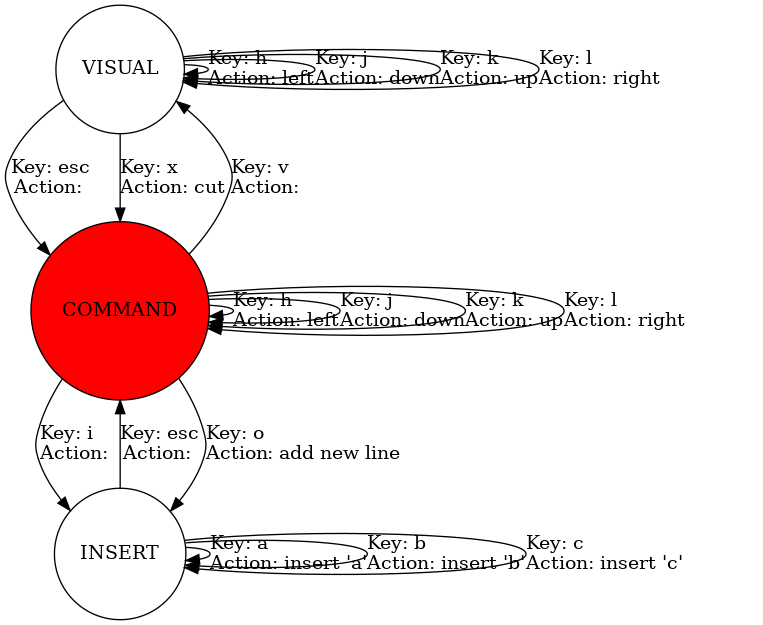

In [9]:
let mut keymap : Graph<Mode, Keymap, petgraph::Directed> = Graph::new();
let visual = keymap.add_node(Mode::VISUAL);
let insert = keymap.add_node(Mode::INSERT);
let command = keymap.add_node(Mode::COMMAND);

keymap.add_edge(
    visual,
    command,
    Keymap{
        key: "esc".to_string(),
        action: "".to_string(),
    }
);

keymap.add_edge(
    visual,
    command,
    Keymap{
        key: "x".to_string(),
        action: "cut".to_string(),
    }
);

keymap.add_edge(
    insert,
    command,
    Keymap{
        key: "esc".to_string(),
        action: "".to_string(),
    }
);

keymap.add_edge(
    command,
    visual,
    Keymap{
        key: "v".to_string(),
        action: "".to_string(),
    }
);

keymap.add_edge(
    command,
    insert,
    Keymap{
        key: "i".to_string(),
        action: "".to_string(),
    }
);

keymap.add_edge(
    command,
    insert,
    Keymap{
        key: "o".to_string(),
        action: "add new line".to_string(),
    }
);

keymap.add_edge(
    insert,
    insert,
    Keymap{
        key: "a".to_string(),
        action: "insert 'a'".to_string(),
    }
);

keymap.add_edge(
    insert,
    insert,
    Keymap{
        key: "b".to_string(),
        action: "insert 'b'".to_string(),
    }
);

keymap.add_edge(
    insert,
    insert,
    Keymap{
        key: "c".to_string(),
        action: "insert 'c'".to_string(),
    }
);

keymap.add_edge(
    command,
    command,
    Keymap{
        key: "h".to_string(),
        action: "left".to_string(),
    }
);

keymap.add_edge(
    command,
    command,
    Keymap{
        key: "j".to_string(),
        action: "down".to_string(),
    }
);

keymap.add_edge(
    command,
    command,
    Keymap{
        key: "k".to_string(),
        action: "up".to_string(),
    }
);

keymap.add_edge(
    command,
    command,
    Keymap{
        key: "l".to_string(),
        action: "right".to_string(),
    }
);

keymap.add_edge(
    visual,
    visual,
    Keymap{
        key: "h".to_string(),
        action: "left".to_string(),
    }
);

keymap.add_edge(
    visual,
    visual,
    Keymap{
        key: "j".to_string(),
        action: "down".to_string(),
    }
);

keymap.add_edge(
    visual,
    visual,
    Keymap{
        key: "k".to_string(),
        action: "up".to_string(),
    }
);

keymap.add_edge(
    visual,
    visual,
    Keymap{
        key: "l".to_string(),
        action: "right".to_string(),
    }
);

let mut keymap_sm = StateMachine::new(
    keymap,
    Mode::COMMAND,
    &|input: &str, ew: Keymap| {
        if input == ew.key {Some(ew.action)} else {None}
    },
).unwrap();

keymap_sm.draw_evcxr();

Obviously, the full keymap is far more messy than this, but you can already see how the state machine works.

In [10]:
{
    let o = keymap_sm.next("o").unwrap();
    println!("Action: {} State: {}", o.0, o.1);
}

Action: add new line State: INSERT


()

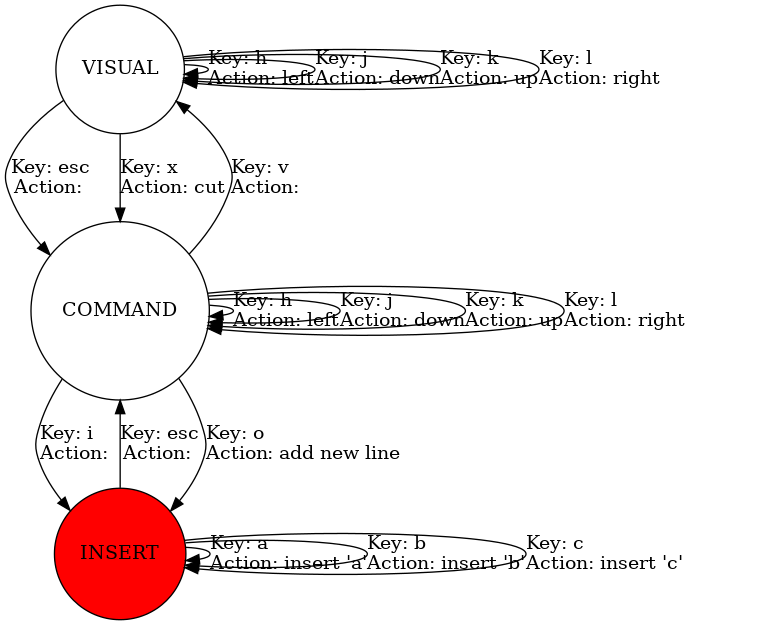

In [11]:
keymap_sm.draw_evcxr();

In [12]:
{
    let o = keymap_sm.next("esc").unwrap();
    println!("Action: {} State: {}", o.0, o.1);
}

Action:  State: COMMAND


()

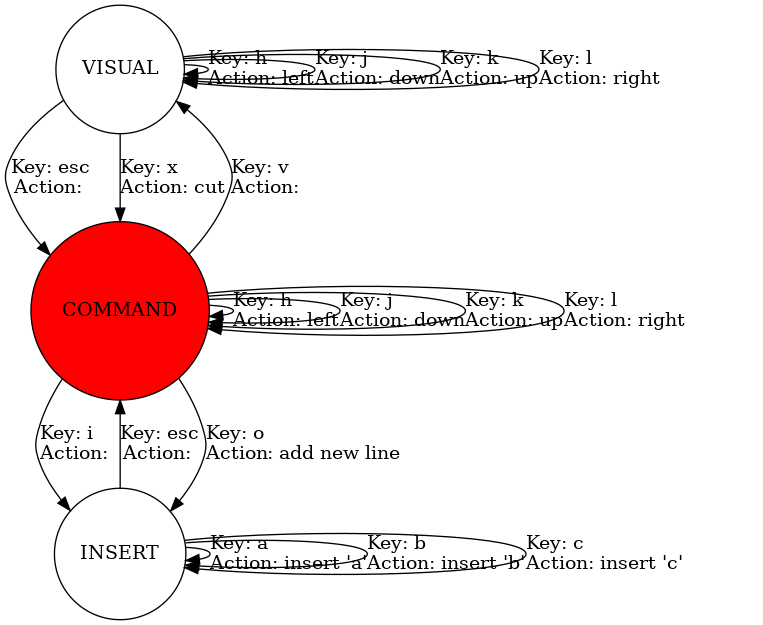

In [13]:
keymap_sm.draw_evcxr();

In [14]:
{
    let o = keymap_sm.next("h").unwrap();
    println!("Action: {} State: {}", o.0, o.1);
}

Action: left State: COMMAND


()

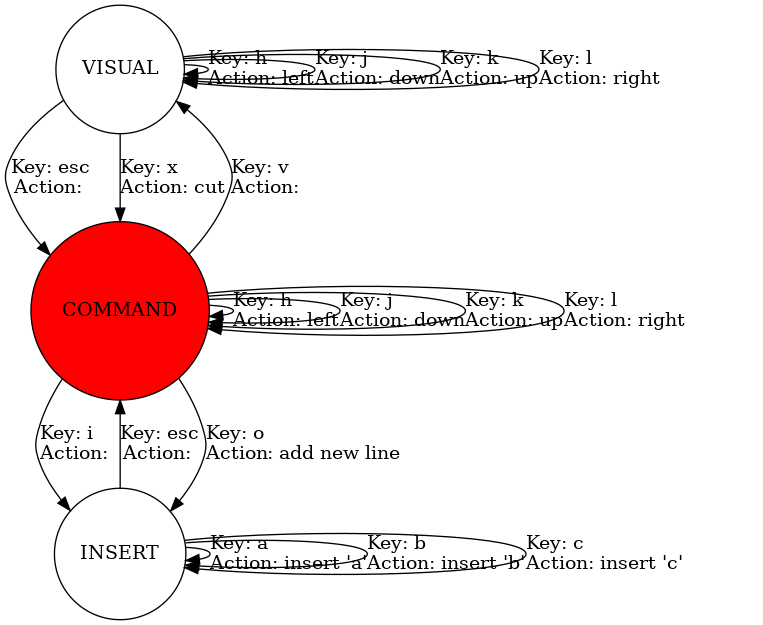

In [15]:
keymap_sm.draw_evcxr();

In [16]:
{
    let o = keymap_sm.next("v").unwrap();
    println!("Action: {} State: {}", o.0, o.1);
}

Action:  State: VISUAL


()

In [17]:
{
    let o = keymap_sm.next("h").unwrap();
    println!("Action: {} State: {}", o.0, o.1);
}

Action: left State: VISUAL


()

In [18]:
{
    let o = keymap_sm.next("h").unwrap();
    println!("Action: {} State: {}", o.0, o.1);
}

Action: left State: VISUAL


()

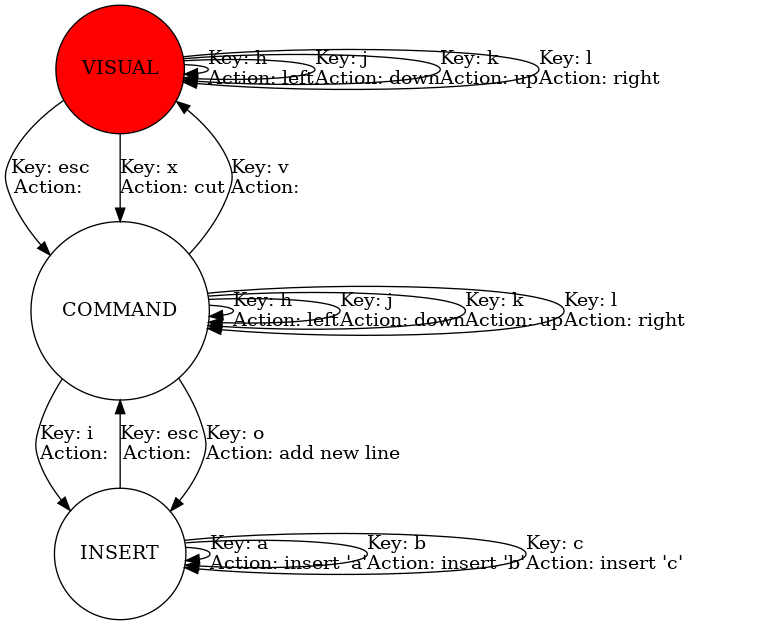

In [19]:
keymap_sm.draw_evcxr();

In [20]:
{
    let o = keymap_sm.next("x").unwrap();
    println!("Action: {} State: {}", o.0, o.1);
}

Action: cut State: COMMAND


()

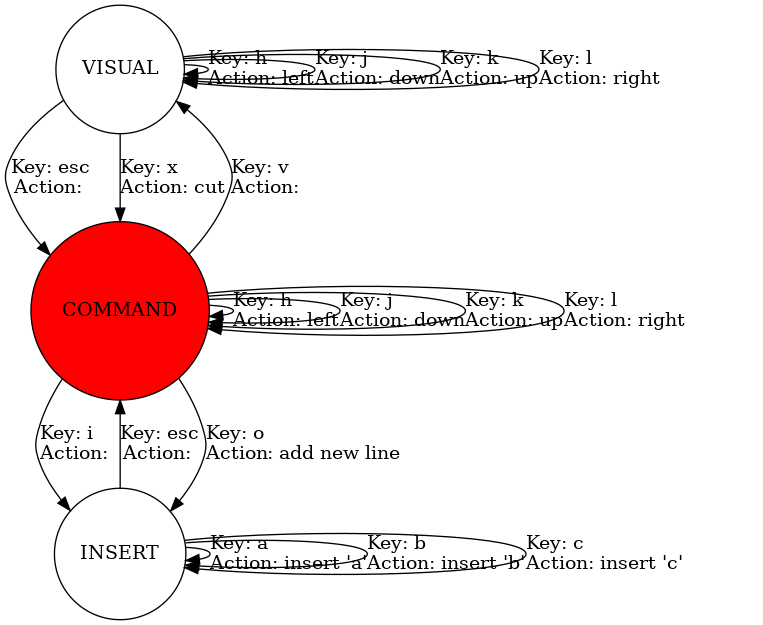

In [21]:
keymap_sm.draw_evcxr();

That really should be all you need to know in order to get working with petgraph-pfsm. Happy hacking!